In [14]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os 
import sys
from PIL import Image
from sys import stdout
import scipy
import scipy.misc
from pylearn2.datasets.preprocessing import ZCA
from pylearn2.expr.preprocessing import global_contrast_normalize


Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [16]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

def face_imshow(img):
    plt.imshow(img.reshape([112,92]), cmap="gray")
    plt.axis('off')   
    

def one_hot_preds(preds):
    t = np.argmax(preds, axis=1)
    r = np.zeros(preds.shape)
    for i in range(t.shape[0]):
        r[i,t[i]] = 1
    return r

def one_hot_class(a):
    b = np.zeros((len(a), np.max(a).astype(int)+1), np.float32)
    b[np.arange(len(a)), a.astype(int)] = 1
    return b

# def unpack_facedataset(path = '/home/yash/Documents/Attacks/Guillaume-Freisz-project/orl_faces', sz=None):
def unpack_facedataset(path='D:\www\graduate_expriment\common\datasets\orl_faces', sz=None):

    """Reads the images in a given folder, resizes images on the fly if size is given.

    Args:
        path: Path to a folder with subfolders representing the subjects (persons).
        sz: A tuple with the size Resizes 

    Returns:
        A list [X,y]

            X: The images, which is a Python list of numpy arrays.
            y: The corresponding labels (the unique number of the subject, person) in a Python list.
    """
    c = 0
    X,y = [], []
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path, filename))
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    X.append(np.asarray(im, dtype=np.uint8))
                    y.append(c)
                except IOError as err:
                    print ("I/O error({0}): {1}".format(err))
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
    X = (np.array(X).astype(np.float32)/255).reshape(len(X), 92*112)
    y = np.array(y).astype(np.float32)
    X = X.reshape(40,10,112*92)
    y = y.reshape(40,10)

    train_x, test_x = X[:,0:7,:], X[:,7:10,:]
    train_y, test_y = y[:,0:7], y[:,7:10]
    train_x, test_x, train_y, test_y = train_x.reshape(40*7,112*92), test_x.reshape(40*3,112*92), train_y.reshape(40*7), test_y.reshape(40*3)
    
    return train_x, test_x, one_hot_class(train_y), one_hot_class(test_y)

def normalize(img, prep, img_shape):
    
    img = prep.inverse(img.reshape(1, -1))[0]
    img /= np.abs(img).max()
    img = np.clip(img, -1., 1.)
    img = (img + 1.) / 2.
    img = global_contrast_normalize(img.reshape(1, -1) * 255, scale=55.)
    img = prep._gpu_matrix_dot(img - prep.mean_, prep.P_)
    return img.reshape(img_shape)

def post_process(img, prep, img_shape):
    # normalize without contrast_normalize and mean_subtract
    img = prep.inverse(img.reshape(1, -1))[0]
    img /= np.abs(img).max()
    img = np.clip(img, -1., 1.)
    img = (img + 1.) / 2.
    return img.reshape(img_shape)


In [17]:
class Model:
    def __init__(self, x, y_):

        in_dim = int(x.get_shape()[1]) # 10304 for Face dataset
        out_dim = int(y_.get_shape()[1]) # 40 for Face dataset
        self.x = x
        # switiching to a simple 2-layer network with relu
        W = weight_variable([in_dim,out_dim])
        b = bias_variable([out_dim])
        self.y = tf.matmul(x,W) + b # output layer
        self.probs = tf.nn.softmax(self.y)
        self.class_inds = tf.argmax(self.probs,1)
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=self.y))
        
        class_ind_correct = tf.argmax(y_,1)
        self.class_prob = (self.probs[0, tf.cast(class_ind_correct[0],tf.int32)])
        self.loss = tf.subtract(tf.constant(1.0), self.class_prob )
        
        self.grads = tf.gradients(self.cross_entropy, x)
        
        self.train_step = tf.train.GradientDescentOptimizer(0.1).minimize(self.cross_entropy)
        
        # performance metrics
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    
    def train(self, train_x, train_y, sess, test_x, test_y,num_iters, disp_freq=50):
        for i in range(num_iters):
            feed_dict = {x: train_x, y_: train_y}
            sess.run(self.train_step, feed_dict)
            if(i%disp_freq == 0):
                train_acc = self.test(train_x, train_y, sess)
                test_acc = self.test(test_x, test_y, sess)
                stdout.write("\r Train Acc. : %f    Test Acc. : %f"% (train_acc, test_acc))
                stdout.flush()
        stdout.write("\n")
            
    
    def test(self, test_x, test_y, sess):
        return (sess.run(self.accuracy, feed_dict={x: test_x, y_: test_y}))
    
    def invert(self, sess, num_iters, lam, img, pre_process, pred_cutoff= 0.99, disp_freq=1):
        
        probs = self.preds(img)
        class_ind = sess.run(self.class_inds, feed_dict= {x:[img]})[0]
        current_X = np.zeros(list(img.shape)[0]).astype(np.float32)
        Y = (one_hot_preds(probs)).astype(np.float32)
        best_X = np.copy(current_X)
        best_loss = 100000.0
        prev_losses = [100000.0]*100
        
        for i in range(num_iters):
            feed_dict = {x: [current_X], y_: Y }
            der,current_loss = sess.run([self.grads, self.loss], feed_dict)
            current_X = np.clip(current_X - lam*(der[0][0]),0.0,1.0)
            current_X = normalize(current_X, pre_process, current_X.shape)
            probs = self.preds(current_X)[0]
            
            if current_loss < best_loss:
                best_loss = current_loss
                best_X = current_X
            
            if current_loss > 2*max(prev_losses):
                print("\n Breaking due to gradient chaos!!")
                break
            
            if pred_cutoff < probs[class_ind]:
                print("\n Above Probability Criteria!: {0}".format(probs[class_ind]))
                break
                
            if i%disp_freq ==0:
#                 plt.close()
#                 face_imshow(post_process(current_X, pre_process, current_X.shape))
#                 plt.show()
                stdout.write("\r Acc: %f and Loss: %f and Best Loss: %f" % (probs[class_ind], current_loss, best_loss))
                stdout.flush()
            
            
        stdout.write("\n")   
        print('Loop Escape.')
        
        current_preds = self.preds(current_X)
        best_preds = self.preds(best_X)
        current_X = post_process(current_X, pre_process, current_X.shape)
        best_X = post_process(best_X, pre_process, best_X.shape)
        return current_X, current_preds, best_X, best_preds

    
    def preds(self, img):
        return sess.run(self.probs, feed_dict= {x:[img]})

def perform_inversion(pre_process, images):
        for img in images:
            face_imshow(img)
            plt.title('Image-Class used for inversion.')
            plt.show()
            print('Predictions: ' + str((model.preds(img))))


            inv_img_last, inv_img_last_p, inv_img_best, inv_img_best_p = model.invert(sess, 100, 0.1, img, pre_process = pre_process)

            face_imshow(inv_img_best)
            plt.title('Best Image after inversion.')
            plt.show()
            print('Predictions: ' + str(inv_img_best_p))
            
            face_imshow(inv_img_last)
            plt.title('Last Iteration Image after inversion.')
            plt.show()
            print('Predictions: ' + str(inv_img_last_p))

In [18]:
train_x, test_x, train_y, test_y  = unpack_facedataset() # 7:3 ratio for train:test 

# GCN and ZCA object!! 
train_x_normalized = global_contrast_normalize(train_x * 255, scale=55.)
zca = ZCA()
zca.fit(train_x_normalized)
print('fit finish')

computing zca of a (280, 10304) matrix
cov estimate took 1.1704068183898926 seconds
eigh() took 145.6485013961792 seconds


In [20]:
x = tf.placeholder(tf.float32, shape=[None, 112*92])
y_ = tf.placeholder(tf.float32, shape=[None, 40])
model = Model(x,y_)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
model.train(train_x, train_y, sess, test_x, test_y, 250)
print('train finish')

 Train Acc. : 1.000000    Test Acc. : 0.908333


D:\www\graduate_expriment\venv\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


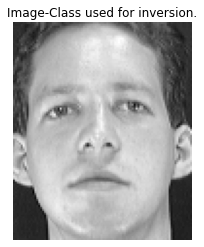

Predictions: [[9.90065038e-01 4.67843493e-05 4.89740632e-05 1.16075644e-04
  1.53085706e-03 4.50490234e-06 5.77666447e-04 2.00024748e-04
  1.29754862e-05 7.66432553e-04 1.06758322e-03 6.47084613e-04
  1.95835255e-05 2.96630816e-07 1.78409892e-03 9.43032865e-06
  1.25435600e-03 6.35973174e-06 6.80300673e-07 2.98114464e-04
  3.98932825e-05 1.41538272e-04 2.37540116e-05 3.25998712e-07
  3.12791708e-05 6.26102919e-05 5.20889844e-05 3.14789795e-05
  7.27739825e-05 6.64310646e-04 2.32235434e-05 1.10895326e-06
  2.84557082e-05 8.86001362e-06 1.55170528e-05 2.90321714e-05
  7.02510588e-05 6.83570033e-05 1.72667918e-04 5.53324571e-06]]
 Acc: 0.645329 and Loss: 0.353415 and Best Loss: 0.317766
Loop Escape.
Predictions: [[6.8073648e-01 2.8063113e-02 7.3360866e-03 4.5287227e-03 1.3040905e-03
  2.4107369e-03 1.1795326e-02 7.1802316e-03 1.2954965e-03 4.3628039e-03
  1.6745700e-02 1.3524325e-02 7.3116613e-03 1.5270621e-02 7.3880941e-04
  4.3952549e-03 6.8071694e-03 1.9920510e-03 1.0968962e-02 1.46617

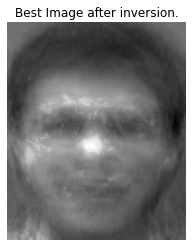

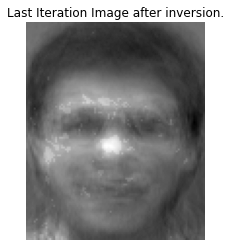

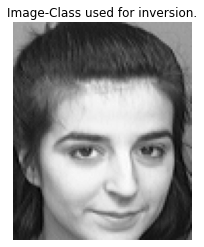

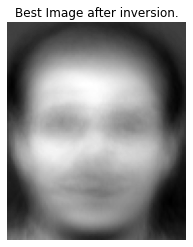

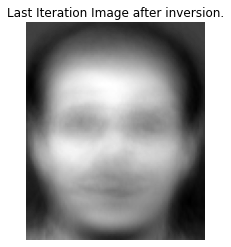

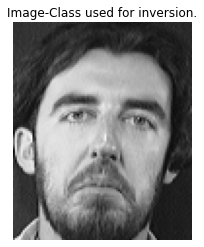

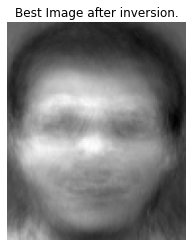

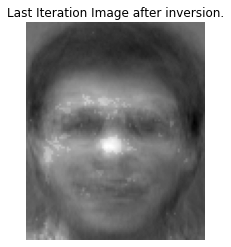

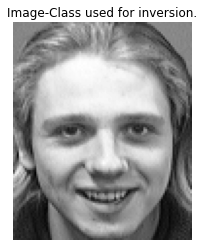

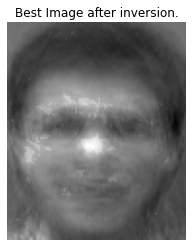

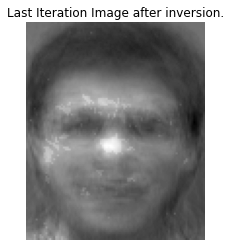

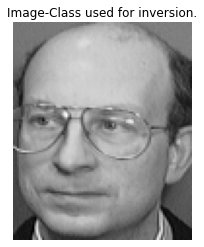

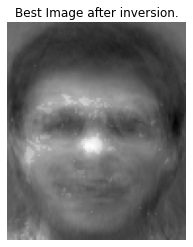

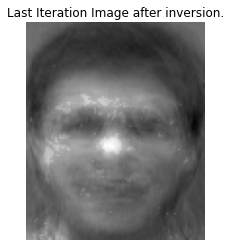

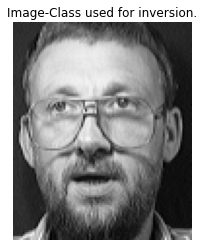

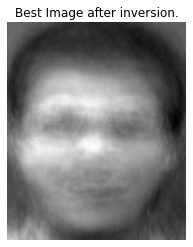

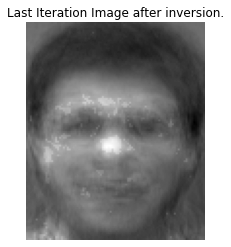

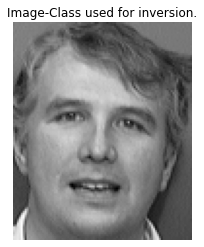

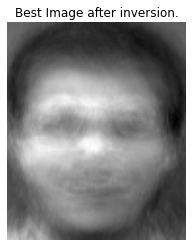

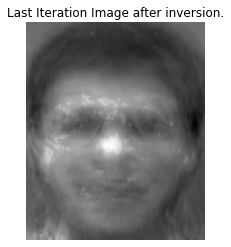

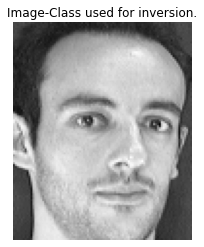

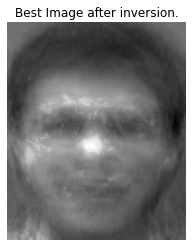

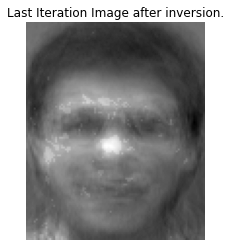

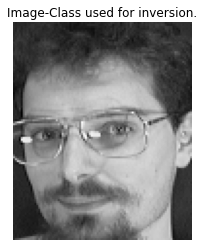

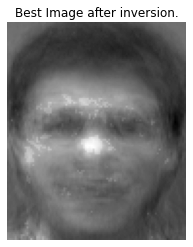

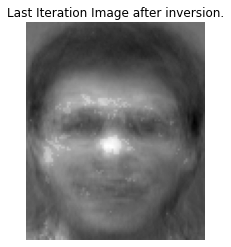

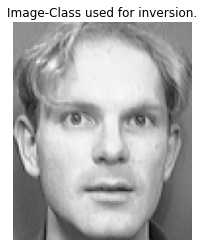

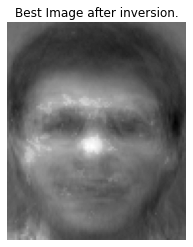

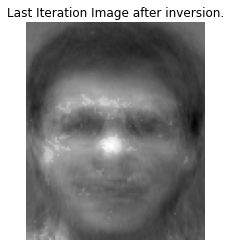

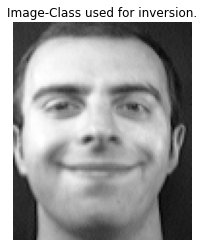

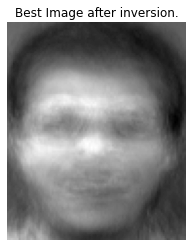

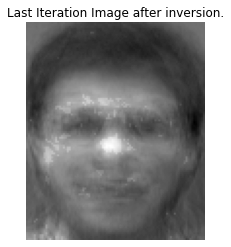

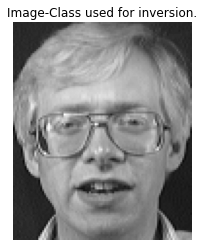

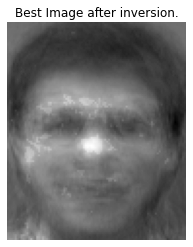

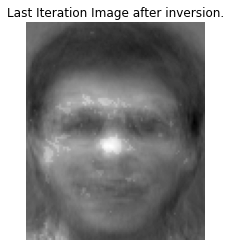

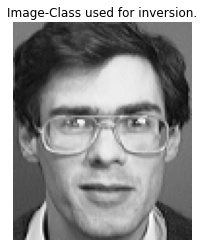

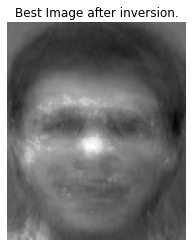

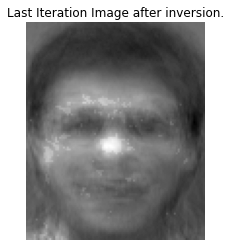

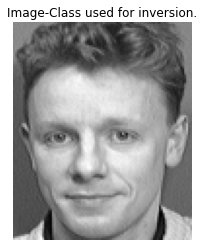

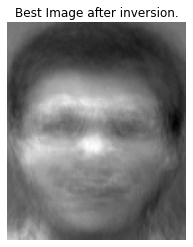

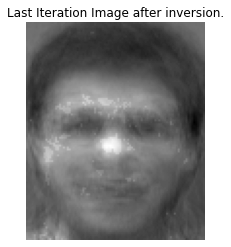

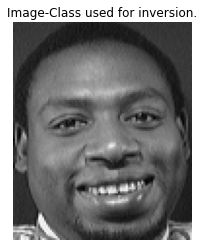

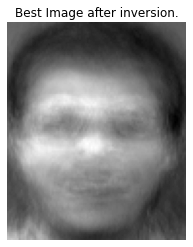

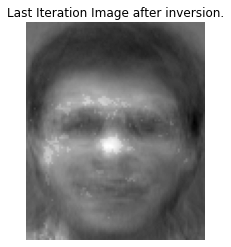

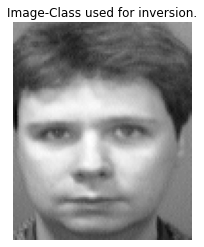

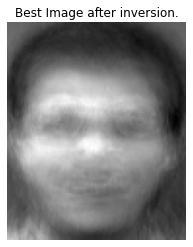

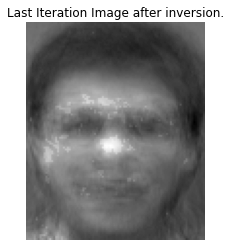

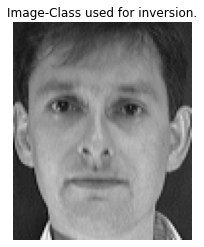

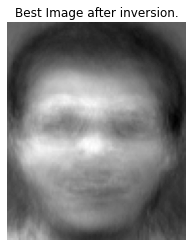

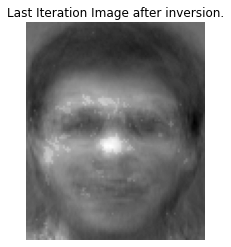

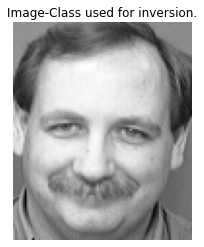

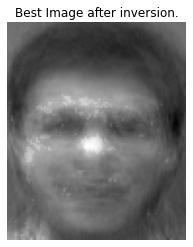

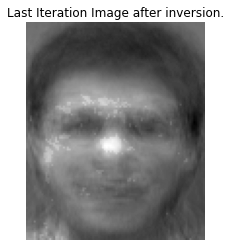

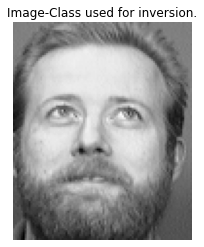

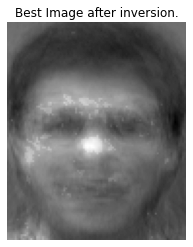

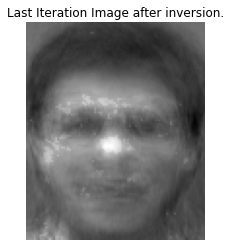

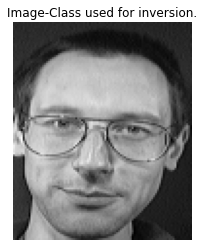

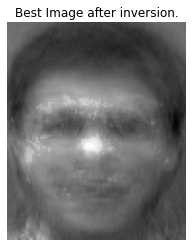

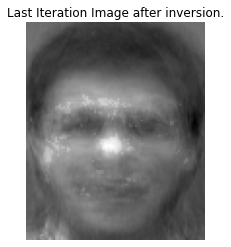

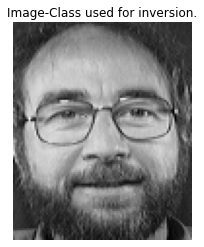

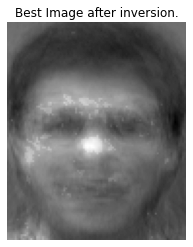

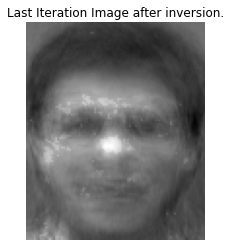

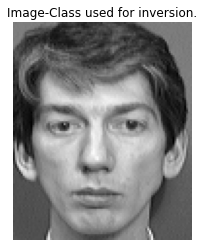

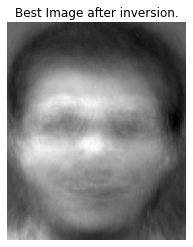

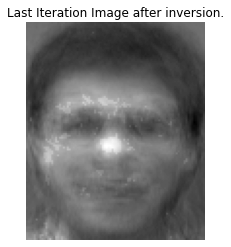

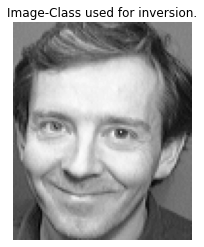

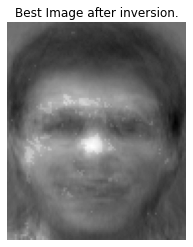

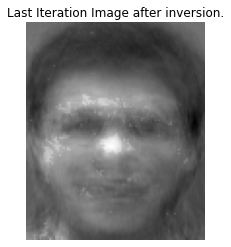

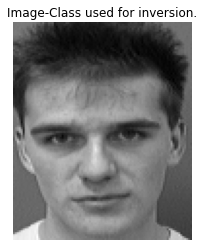

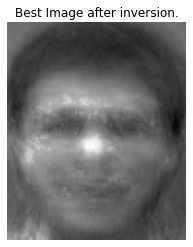

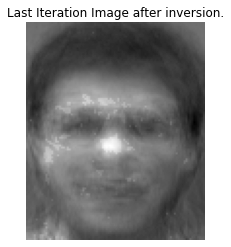

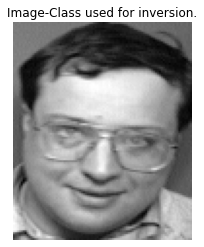

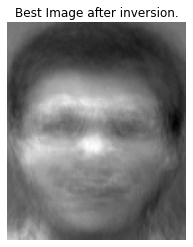

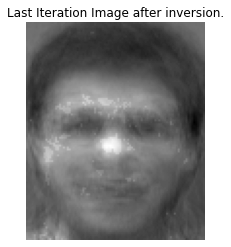

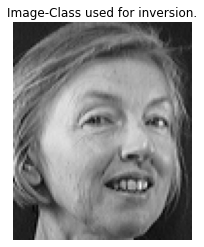

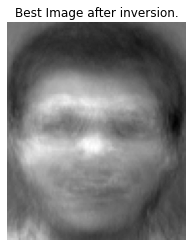

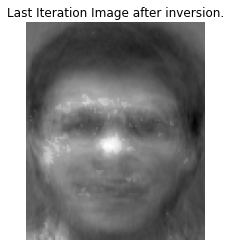

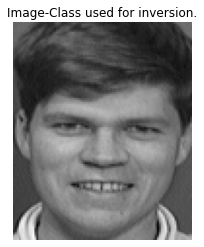

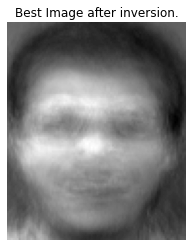

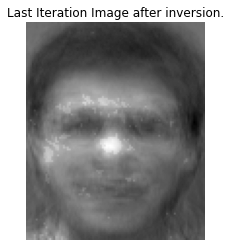

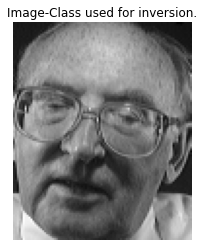

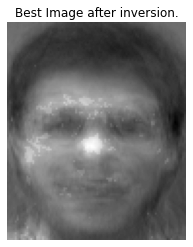

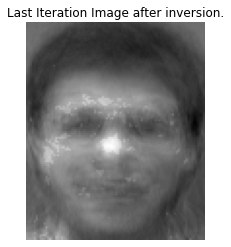

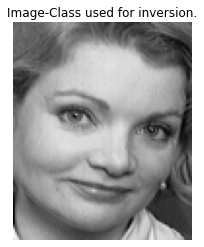

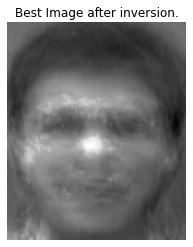

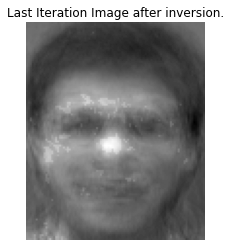

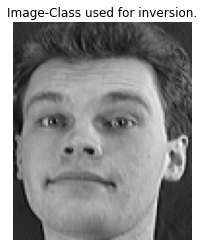

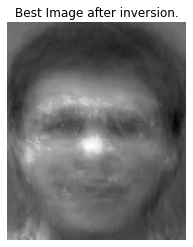

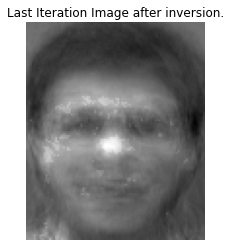

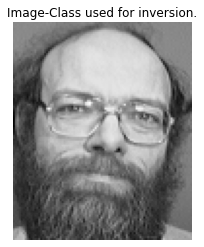

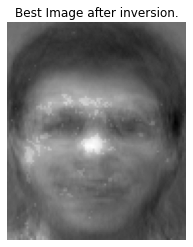

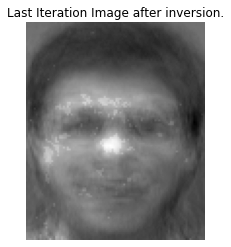

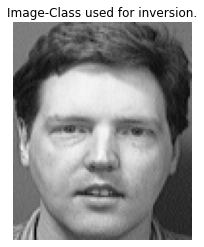

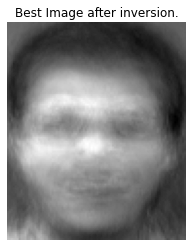

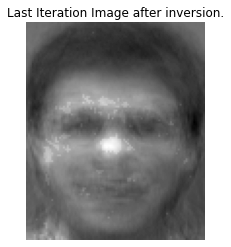

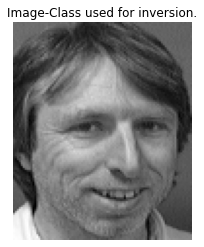

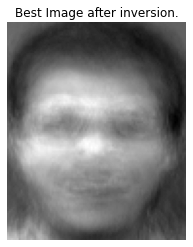

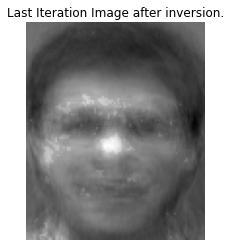

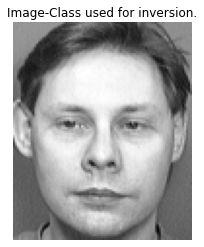

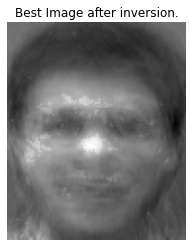

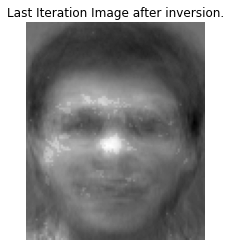

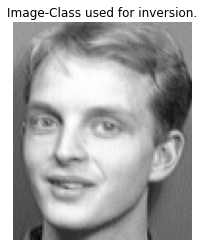

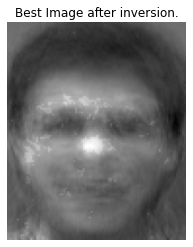

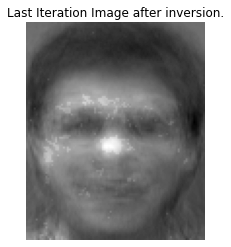

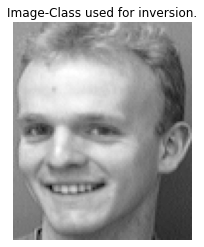

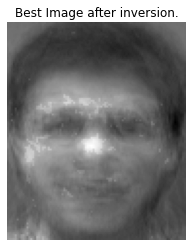

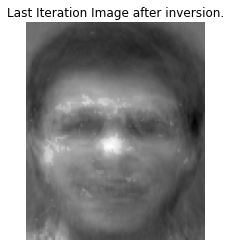

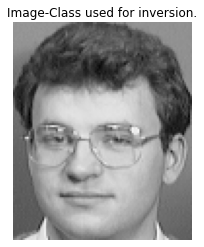

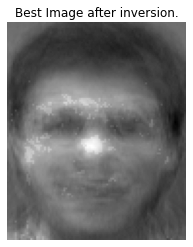

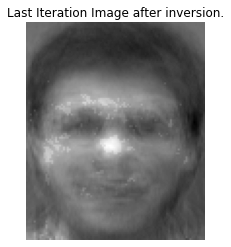

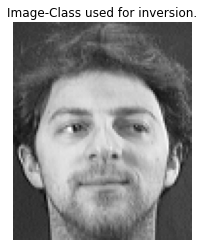

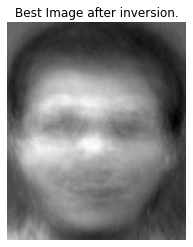

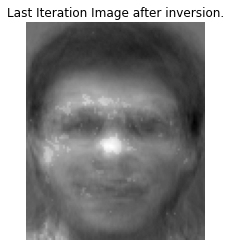

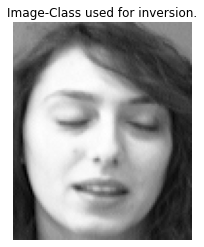

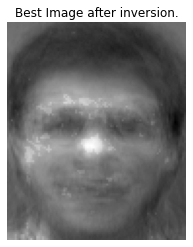

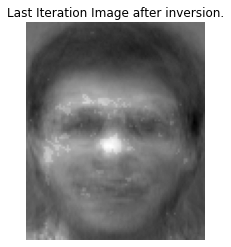

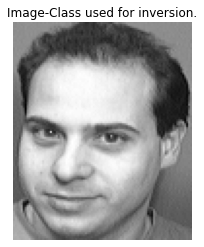

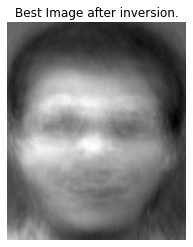

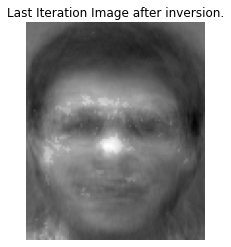

In [21]:
perform_inversion(zca, test_x[0::3])
print('inversion finish')

In [ ]:
"""
train_x, test_x, train_y, test_y  = unpack_facedataset() # 7:3 ratio for train:test 
zca = ZCA()
zca.fit(train_x[:2])
img = train_x[10]
img = normalize(img)
face_imshow(img,zca,img.shape)
"""

"""
from sys import stdout
from time import sleep
import numpy as np

a = np.array([10.2,.2,24.5,3,4,5,6,7,8,9,10,11])
for i in range(1,10):
    stdout.write("\r Hye there %d hi deer %d " % (a,i))
    stdout.flush()
    sleep(.25)
stdout.write("\n") # move the cursor to the next line

"""